### 知识点1：enumerate()
enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中。


In [55]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
print(list(enumerate(seasons)))
print(list(enumerate(seasons, start=1)))       # 下标从 1 开始

[(0, 'Spring'), (1, 'Summer'), (2, 'Fall'), (3, 'Winter')]
[(1, 'Spring'), (2, 'Summer'), (3, 'Fall'), (4, 'Winter')]


### 知识点2： np.ravel()和np.flatten()
两者的功能是一致的，将多维数组降为一维，但是两者的区别是返回拷贝还是返回视图，np.flatten(0返回一份拷贝，对拷贝所做修改不会影响原始矩阵，而np.ravel()返回的是视图，修改时会影响原始矩阵 

In [56]:
import numpy as np
a = np.array([[1 , 2] , [3 , 4]])
b = a.flatten()
print('b:' , b)
c = a.ravel()
print('c:' , c)
d = a.ravel('F')
print('d:' , d)

# 二者的区别
b[0] = 10
print('a:' , a)
c[0] = 10
print('a:' , a)

b: [1 2 3 4]
c: [1 2 3 4]
d: [1 3 2 4]
a: [[1 2]
 [3 4]]
a: [[10  2]
 [ 3  4]]


### 知识点3：reshape()

也就是说，先前我们不知道z的shape属性是多少，但是想让z变成只有一列，行数不知道多少，通过`z.reshape(-1,1)`，Numpy自动计算出有12行，新的数组shape属性为(16, 1)，与原来的(4, 4)配套。

如果参数是-1，那么就是与元素总数相配套，进行待定

In [57]:
import numpy as np
z = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])
print(z.reshape(-1))
print(z.reshape(-1,1))
print(z.reshape(-1,2))


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]]
[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]
 [13 14]
 [15 16]]


### 利用混合高斯进行聚类的例子
高斯混合模型假设所有样本点是由 K 个高斯分布混合而成的，如统计一个班级里所有同学的身高，这些身高就是由男生身高和女生身高这两个高斯分布混合而成的。假设我们已知班上所有同学的性别，如下图所示，那么可以很容易根据样本身高和样本类别求得男生身高和女生身高这两个高斯分布的参数。
![1](https://segmentfault.com/img/remote/1460000016919747)

当我们只有身高数据的时候，如何将身高数据聚成男女生两个簇？这就是高斯混合分布可以解决的问题。高斯混合分布首先将该问题转换为包含隐变量（即每条样本属于不同类别的概率）和模型参数（即男女生两个高斯分布的参数）的极大似然估计问题。由于该极大似然估计问题中包含隐变量和模型参数，所以无法用传统的求偏导的方法求得。这时，需要利用EM算法，即期望最大化算法求解参数。

代码演示了高斯混合模型的几种协方差类型(通过鸢尾花数据集的前两个维度)

In [ ]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()
# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))
X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}#这样创建字典的方式很稀奇，即创建拥有不同参数的模型，放进字典中

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100#这只是聚类准确度
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

(400, 2) (400,)
[[ 7.75288501 -1.23451069]
 [ 3.23883891 -0.98176239]
 [ 0.84996404  2.0586494 ]
 [ 4.43914909  0.93443404]
 [ 2.60482657 -1.91808949]]
[[ 7.76850893 -1.31434332]
 [ 4.73892808  0.92511492]
 [ 0.81556987  1.88005522]
 [ 2.8945385  -1.50269869]
 [ 3.87699805  1.02193078]]
[[ 7.75288501 -1.23451069]
 [ 3.23883891 -0.98176239]
 [ 0.84996404  2.0586494 ]
 [ 4.43914909  0.93443404]
 [ 2.60482657 -1.91808949]]


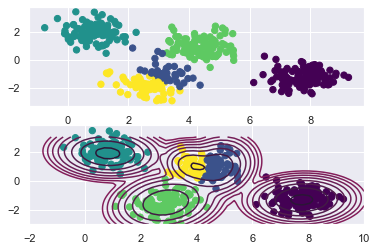

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#产生实验数据
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,cluster_std=0.60, random_state=0)
print(X.shape,y_true.shape)
X = X[:, ::-1] #交换列是为了方便画图

from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

plt.subplot(2,  1,  1)
gmm = GaussianMixture(n_components=5).fit(X[0:200])
print(gmm.means_)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

plt.subplot(2,  1,  2)
gmmb = GaussianMixture(n_components=5).fit(X[200:400])
print(gmmb.means_)
print(gmm.means_)
labels = gmmb.predict(X)
# print(gmmb.get_params())
# print(gmmb.means_.shape, gmmb.covariances_.shape, gmmb.weights_.shape)
# print(gmmb.means_, gmmb.covariances_, gmmb.weights_,gmmb.precisions_)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
# display predicted scores by the model as a contour plot
x = np.linspace(-2., 10.)#创建默认个数为50的一列数
y = np.linspace(-3., 3.)
X, Y = np.meshgrid(x, y)#生成点坐标矩阵https://blog.csdn.net/lllxxq141592654/article/details/81532855
XX = np.array([X.ravel(), Y.ravel()]).T#ravel()扁平函数，将数组展开成一维,XX就是一组点的坐标
Z = -gmmb.score_samples(XX)#Z为该样本点的加权可能性
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),levels=np.linspace(0, 10, 10))
#绘制等高线https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.contourf.html?highlight=contourf#matplotlib.pyplot.contourf
#np.logspace(0, 3, 10)生成1到1000的等比数列

### 高斯混合气体的密度估计

绘制两高斯混合的密度估计图。数据由两个不同中心和协方差矩阵的高斯分布产生。

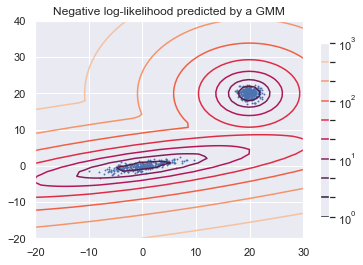

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)
# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])
# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)
# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

### 高斯混合模型选择

该实例表明，利用信息理论准则(BIC)，高斯混合模型可以进行模型选择。模型选择既涉及协方差类型，又涉及模型中的组件数量。在这种情况下，AIC也提供正确的结果(没有显示以节省时间)，但如果问题是确定正确的模型，则BIC更适合。与贝叶斯方法不同，这类推论是无先验的。在这种情况下，选择具有2个分量和完全协方差(对应于真正的生成模型)的模型。

Automatically created module for IPython interactive environment


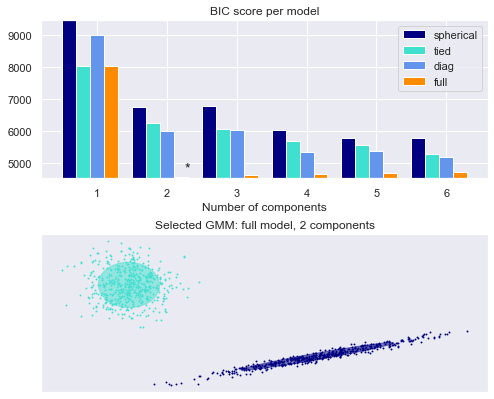

In [28]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

## [高斯混合模型椭球体](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py)

用期望最大化(高斯混合类)和变分推论(贝叶斯混合类模型与狄利克雷过程先验)绘制两个高斯混合模型的置信椭球体。这两种模型都可以访问5个组件来匹配数据。请注意，期望最大化模型将必然使用所有五个部分，而变分推理模型将有效地只使用适合度所需的部分。

在这里，我们可以看到期望最大化模型任意地分割了一些组件，因为它试图适应太多的组件，而狄利克雷过程模型自动地调整它的状态数。这个例子不显示它,当我们在一个低维空间,但狄利克雷过程模型的另一个优点是,它可以适应全协方差矩阵有效即使有例子每个集群比有维度的数据,由于正则化属性的推理算法。

(5, 2) (5, 2, 2)


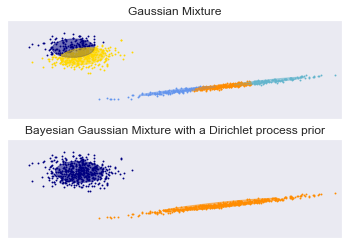

In [17]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
# print(gmm.means_, gmm.covariances_)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')
# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5,
                                        covariance_type='full').fit(X)
print(dpgmm.means_.shape, dpgmm.covariances_.shape)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

### 高斯混合模型正弦曲线

这个例子演示了高斯混合模型的特性，它适用于没有从混合的高斯随机变量中采样的数据。数据集是由100个点组成的，这些点沿着一个有噪声的正弦曲线松散地间隔。因此，对于高斯分量的数量，不存在基真值。

第一个模型是一个经典的高斯混合模型，有10个分量符合期望最大化算法。

第二种模型是贝叶斯高斯混合模型，采用狄利克雷过程先验拟合变分推理。由于浓度先验值较低，使得模型有利于活性组分数量较少。该模型“决定”将其建模能力集中于数据集结构的总体情况:使用非对角协方差矩阵建模的具有交替方向的点组。这些交替的方向大致捕捉了原始正弦信号的交替性质。

第三个模型也是一个具有狄利克雷过程先验的贝叶斯高斯混合模型，但这次浓度先验的值更高，使模型更自由地对数据的细粒度结构进行建模。结果是混合了大量的活动组件，这类似于第一个模型，我们随意决定将组件的数量固定为10。哪种模式是最好的是一个主观判断的问题:我们想要支持的模型,只有捕捉大局总结和解释大部分的数据结构而忽视细节或者我们喜欢模型,密切关注高密度区域的信号吗?最后两个面板显示了我们如何从最后两个模型中取样。得到的样本分布与原始数据分布并不完全相同。这种差异主要源于我们使用的模型的近似误差，该模型假设数据是由有限数量的高斯分量生成的，而不是由连续的有噪声的正弦曲线生成的。

Automatically created module for IPython interactive environment


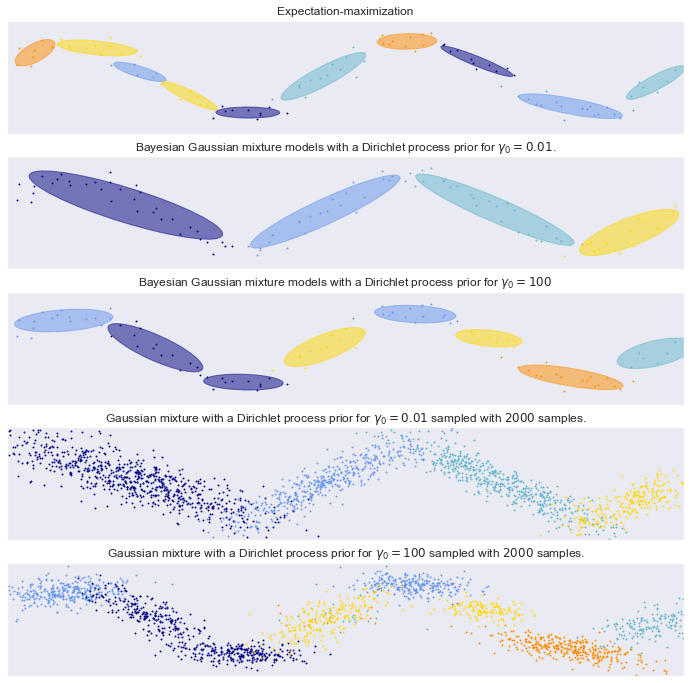

In [20]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


# Parameters
n_samples = 100

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4. * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3. * (np.sin(x) + np.random.normal(0, .2))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=.04, top=0.95, hspace=.2, wspace=.05,
                    left=.03, right=.97)

# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Expectation-maximization')

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="random", max_iter=100, random_state=2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=0.01$.")

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 0,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=0.01$ sampled with $2000$ samples.")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e+2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 1,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=100$ sampled with $2000$ samples.")

plt.show()

## 浓度先验型变异贝叶斯高斯混合

分析这个例子中情节椭圆体从玩具获得数据集(三个高斯函数的混合物)安装前用狄利克雷分布BayesianGaussianMixture类模(weight_concentration_prior_type = dirichlet_distribution)和狄利克雷过程之前(weight_concentration_prior_type =“dirichlet_process”)。

在每个图上，我们绘制了三个不同的权重浓度先验值的结果。bayesiangaussianmix类可以自动调整其混合组件的数量。参数weight_concentration_prior与产生的非零权重的组件数量直接相关。为浓度先验指定一个较低的值将使模型将大部分权重放在少数组件上，使其余组件的权重非常接近于零。浓度先验的高值将允许更多的组分在混合物中起作用。Dirichlet流程prior允许定义无限数量的组件，并自动选择正确的组件数量:只有在必要时才激活组件。与此相反，具有狄利克雷分布先验的经典有限混合模型倾向于更均匀加权的分量，因此倾向于将自然簇划分为不必要的子分量。

Automatically created module for IPython interactive environment


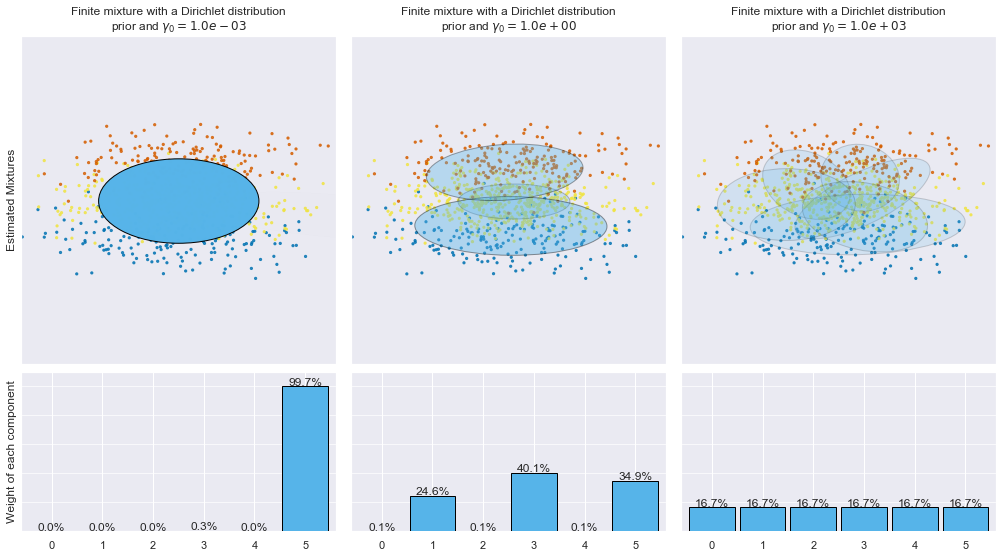

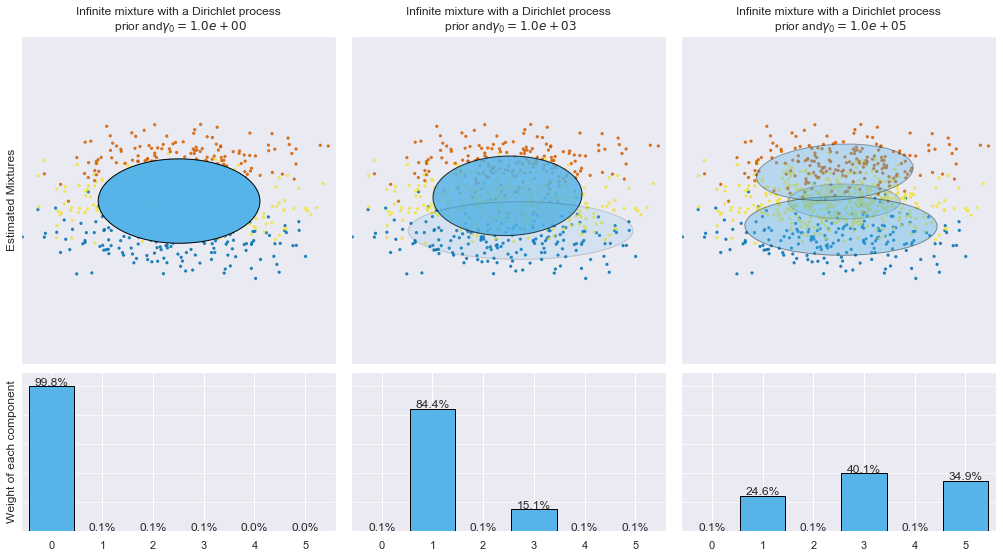

In [19]:
# Author: Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.mixture import BayesianGaussianMixture

print(__doc__)


def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker='o', color=colors[y], alpha=0.8)
    ax1.set_xlim(-2., 2.)
    ax1.set_ylim(-3., 3.)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_,
                  estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(k, w, width=0.9, color='#56B4E9', zorder=3,
                align='center', edgecolor='black')
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.),
                 horizontalalignment='center')
    ax2.set_xlim(-.6, 2 * n_components - .4)
    ax2.set_ylim(0., 1.1)
    ax2.tick_params(axis='y', which='both', left=False,
                    right=False, labelleft=False)
    ax2.tick_params(axis='x', which='both', top=False)

    if plot_title:
        ax1.set_ylabel('Estimated Mixtures')
        ax2.set_ylabel('Weight of each component')

# Parameters of the dataset
random_state, n_components, n_features = 2, 3, 2
colors = np.array(['#0072B2', '#F0E442', '#D55E00'])

covars = np.array([[[.7, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]]])
samples = np.array([200, 500, 200])
means = np.array([[.0, -.70],
                  [.0, .0],
                  [.0, .70]])

# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    ("Finite mixture with a Dirichlet distribution\nprior and "
     r"$\gamma_0=$", BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_distribution",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,
        random_state=random_state), [0.001, 1, 1000]),
    ("Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
     BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_process",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,
        random_state=random_state), [1, 1000, 100000])]

# Generate data
rng = np.random.RandomState(random_state)
X = np.vstack([
    rng.multivariate_normal(means[j], covars[j], samples[j])
    for j in range(n_components)])
y = np.concatenate([np.full(samples[j], j, dtype=int)
                    for j in range(n_components)])

# Plot results in two different figures
for (title, estimator, concentrations_prior) in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(bottom=.04, top=0.90, hspace=.05, wspace=.05,
                        left=.03, right=.99)

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(plt.subplot(gs[0:2, k]), plt.subplot(gs[2, k]), estimator,
                     X, y, r"%s$%.1e$" % (title, concentration),
                     plot_title=k == 0)

plt.show()